In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import owlready2 as owl
from owlready2 import *
owlready2.reasoning.JAVA_MEMORY = 20000

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

torch.manual_seed(33)

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation




In [2]:
from create_pytorch_dataset import GeometricInterpretation, CanonicalModel, EntityEmbedding, SCALE_FACTOR
from create_pytorch_dataset import entity_to_idx_vocab, concept_to_idx_vocab, role_to_idx_vocab, idx_to_entity_vocab, idx_to_concept_vocab, idx_to_role_vocab, idx_finder_dict
from create_pytorch_dataset import trainConceptDataset, testConceptDataset, trainRoleDataset, testRoleDataset, train_ConceptDataLoader, test_ConceptDataLoader, train_RoleDataLoader, test_RoleDataLoader, RoleDataLoader, ConceptDataLoader


All Concept Names and Concept Intersections have been preprocessed for the creation of the canonical model.

All restrictions have been preprocessed for the creation of the canonical model.
Starting to reason.



* Owlready2 * Running HermiT...
    java -Xmx200000M -cp /opt/homebrew/Caskroom/miniforge/base/envs/kgenv/lib/python3.11/site-packages/owlready2/hermit:/opt/homebrew/Caskroom/miniforge/base/envs/kgenv/lib/python3.11/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/wg/g5861gcs6k5d3rbq_rncztjw0000gn/T/tmp6r1zah6z



Done reasoning. Creating the canonical model.

Concluded creating canonical model.
================EMBEDDING DIMENSION================
Concept Name dimensions: 9
The number of role names is: 5
The size of the domain is: 90
Role names dimensions: 450

Final embedding dimension: 458
The final dimension for role regions is: 916

===============FINISHED EMBEDDINGS===============
There are 90 vector embeddings.

============FINISHED INTERPS CONCEPT=============
There are 9 regions for concept names.

=============FINISHED INTERPS ROLES==============
There are 5 regions for role names.

Len Concept Assertions Dataset: 1688
Size of Role Assertions Dataset: 1118



* Owlready2 * HermiT took 0.44031190872192383 seconds
* Owlready * Reparenting entity.Q16019673: {owl.Thing} => {Class.Father}
* Owlready * Reparenting entity.Q2397531: {owl.Thing} => {Class.Father, Class.Child}
* Owlready * Reparenting entity.Q57209: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q829669: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q11090991: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q10323203: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q2840038: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q60610: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q213716: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q312110: {owl.Thing} => {Class.Father, Class.Child, Class.Sibling, Class.Spouse}
* Owlready * Reparenting entity.Q22876077: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q2446902: {owl.Thing} => {Class.Father, Class.Child}
* Owlready * Repa

In [3]:
from FaithEL_model import FaithEL
from utils import save_model, train_model, plot_score_hak, plot_model

In [4]:
CENTROID_SCORE = True # When set to True, model scores assertion w.r.t distance to the centroid and to the moving parameter for concepts/roles
LR = 0.001
PHI = 1 # Weighs the loss obtained by computing the distance between the role/concept params to the centroid
GAMMA = 1 # Weighs the loss obtained by computing the distance between the role/concept param to the individual/ind_concat parameters
PSI = 0.7 # Weights the negative loss obtained by computing the distance between the real individual/ind_concat and neg sampled individuals/ind_concats
RADIUS = SCALE_FACTOR/2 + 0.1
EMB_DIM = 458

LOG_EPOCH = 10000
EVAL_TRAIN = False
EPOCHS = 1000
EVAL_FREQ = 20

NEG_SAMPLING = True
PLOT_LOSS = True

TRAINING_CATEGORY = 2 # 0 = both, 1 = concept only, 2 = role only

DIM1 = 0
DIM2 = 1

loss_fn = nn.MSELoss()

In [5]:
torch.manual_seed(269)

model = FaithEL(EMB_DIM, PHI, RADIUS, GAMMA, PSI,
                entity_to_idx_vocab, concept_to_idx_vocab, role_to_idx_vocab,
                )

optimizer = optim.Adam(model.parameters(), lr=LR)

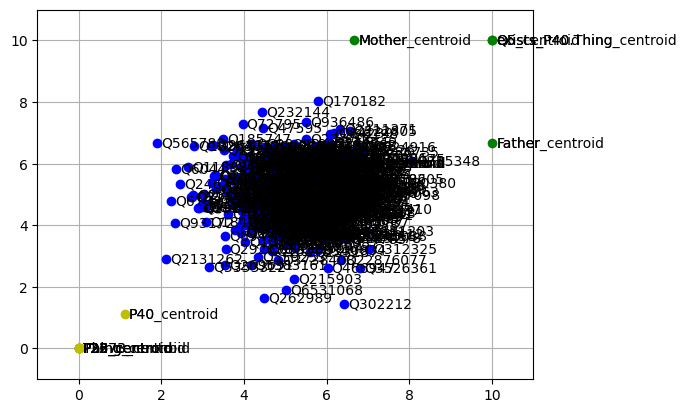

In [6]:
plot_model(model, GeometricInterpretation, idx_to_entity_vocab, idx_to_concept_vocab, idx_to_role_vocab, SCALE_FACTOR, DIM1, DIM2)

In [7]:
model_list = []

Epoch 20: Initiating evaluation. 

Epoch 40: Initiating evaluation. 

Epoch 60: Initiating evaluation. 

Epoch 80: Initiating evaluation. 

Epoch 100: Initiating evaluation. 

Epoch 120: Initiating evaluation. 

Epoch 140: Initiating evaluation. 

Epoch 160: Initiating evaluation. 

Epoch 180: Initiating evaluation. 

Epoch 200: Initiating evaluation. 



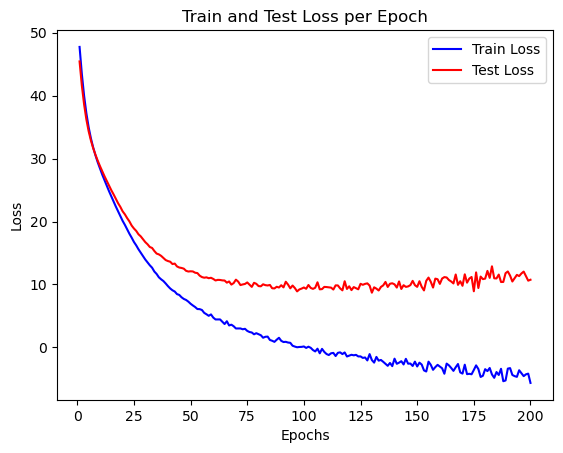

In [8]:
train_loss_list, test_loss_list, train_hits_at_k_concept, test_hits_at_k_concept, train_hits_at_k_role, test_hits_at_k_role, = train_model(model, GeometricInterpretation,
                                                                                                                                           train_ConceptDataLoader, train_RoleDataLoader, test_ConceptDataLoader, test_RoleDataLoader,
                                                                                                                                           trainConceptDataset, testConceptDataset, trainRoleDataset, testRoleDataset,
                                                                                                                                           EPOCHS, LOG_EPOCH, EVAL_FREQ, EVAL_TRAIN, loss_fn, optimizer,
                                                                                                                                           idx_to_entity_vocab, entity_to_idx_vocab,
                                                                                                                                           idx_to_concept_vocab, concept_to_idx_vocab,
                                                                                                                                           idx_to_role_vocab, role_to_idx_vocab,
                                                                                                                                           CENTROID_SCORE, NEG_SAMPLING, PLOT_LOSS, TRAINING_CATEGORY
                                                                                                                                           )

model_list.append(save_model(CENTROID_SCORE, LR, PHI, GAMMA, PSI, EMB_DIM, EPOCHS, LOG_EPOCH, EVAL_FREQ, EVAL_TRAIN,
                             loss_fn, model, optimizer, train_loss_list, test_loss_list, train_hits_at_k_concept, test_hits_at_k_concept, train_hits_at_k_role, test_hits_at_k_role))

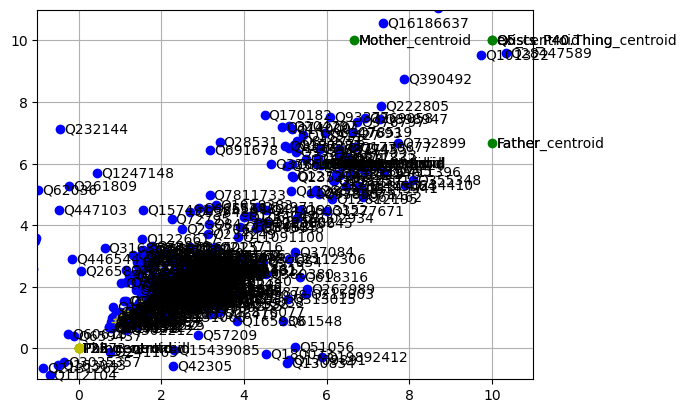

In [9]:
plot_model(model, GeometricInterpretation, idx_to_entity_vocab, idx_to_concept_vocab, idx_to_role_vocab, SCALE_FACTOR, DIM1, DIM2)

In [16]:
pos_list = -1
TOPK = 1

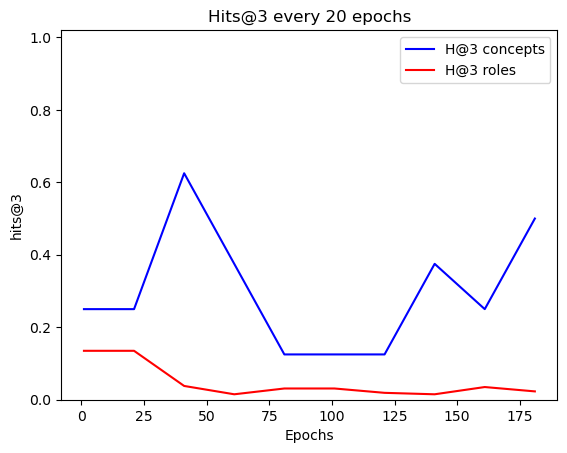

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

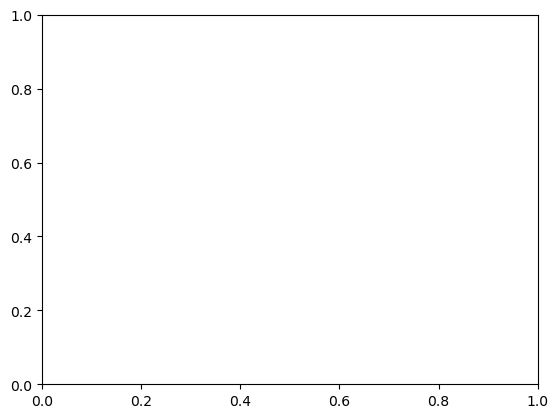

In [17]:
plot_score_hak(model_list[pos_list]['test_hits_at_k_concept'], model_list[pos_list]['test_hits_at_k_role'], TOPK, model_list[pos_list]['epochs'], model_list[pos_list]['eval_freq'])
plot_score_hak(model_list[pos_list]['train_hits_at_k_concept'], model_list[pos_list]['train_hits_at_k_role'], TOPK, model_list[pos_list]['epochs'], model_list[pos_list]['eval_freq'])